# ANOVA and Cochran's Q Test for Sensory Data Analysis

This notebook demonstrates two important statistical tests used in sensory analysis:

1. **One-Way ANOVA (Analysis of Variance)**: Tests whether there are statistically significant differences between the means of three or more groups. We'll use it to determine if wine quality ratings differ significantly in terms of alcohol content.

2. **Cochran's Q Test**: A non-parametric test used to determine if there are differences in proportions across multiple related groups. This is particularly useful for sensory panel data where the same subjects are tested under different conditions.

**Learning Objectives:**
- Understand when to use ANOVA vs. other statistical tests
- Perform one-way ANOVA and interpret results
- Conduct post-hoc tests (Tukey HSD) to identify which groups differ
- Check ANOVA assumptions (normality, homogeneity of variance)
- Understand and apply Cochran's Q test for categorical data
- Create appropriate visualizations for statistical results



## 1. Import Required Libraries

We'll import the necessary libraries for data manipulation, statistical analysis, and visualization. Make sure these are installed in your environment.

In [14]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Statistical analysis libraries
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.runs import cochrans_q

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Installation notes (if needed):
# pip install pandas numpy scipy statsmodels matplotlib seaborn
# OR with conda:
# conda install pandas numpy scipy statsmodels matplotlib seaborn

## 2. Set Custom Color Theme (Optional)

We'll use custom colors for our visualizations. This step is optional but helps create consistent, branded visualizations. Here we use University of Illinois colors.


In [15]:
# Custom Illinois colors for consistent visualization theme
illiniorange = "#FF5F05"
illiniblue = "#13294B"


## 3. Load and Prepare Data

We'll load the wine quality dataset and prepare it for ANOVA analysis. ANOVA requires the independent variable (quality) to be treated as a categorical factor, even if it's originally numeric.


In [16]:
# Load the dataset
df = pd.read_csv("data/winequality-red.csv", sep=',')

# Convert quality to categorical for ANOVA
# ANOVA treats groups as categories, not as numeric values
df["quality_cat"] = df["quality"].astype("category")

# Display the distribution of quality categories
print("Distribution of quality categories:")
print(df["quality_cat"].value_counts().sort_index())

Distribution of quality categories:
quality_cat
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


## 4. One-Way ANOVA: Testing Differences in Alcohol Content by Quality

**ANOVA (Analysis of Variance)** tests whether there are statistically significant differences between the means of three or more groups. 

**Research Question:** Do wines of different quality ratings have significantly different alcohol content?

**Null Hypothesis (H₀):** All quality groups have the same mean alcohol content.

**Alternative Hypothesis (H₁):** At least one quality group has a different mean alcohol content.

We'll use a one-way ANOVA where:
- **Dependent variable (response)**: Alcohol content
- **Independent variable (factor)**: Quality category


In [17]:
# Fit the ANOVA model
# C(quality_cat) tells statsmodels to treat quality_cat as a categorical variable
model = ols("alcohol ~ C(quality_cat)", data=df).fit()

# Perform ANOVA and display results
# Type II Sum of Squares is appropriate for one-way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:")
print("="*60)
print(anova_table)
print("\nInterpretation:")
print("- F-statistic: Measures the ratio of between-group to within-group variance")
print("- p-value (PR(>F)): Probability of observing this result if H₀ is true")
print("- If p < 0.05, we reject H₀ and conclude groups differ significantly")


ANOVA Results:
                     sum_sq      df           F         PR(>F)
C(quality_cat)   483.937982     5.0  115.854797  1.209895e-104
Residual        1330.826555  1593.0         NaN            NaN

Interpretation:
- F-statistic: Measures the ratio of between-group to within-group variance
- p-value (PR(>F)): Probability of observing this result if H₀ is true
- If p < 0.05, we reject H₀ and conclude groups differ significantly


### 4.1. Checking ANOVA Assumptions

ANOVA has several assumptions that should be checked:
1. **Normality**: Residuals should be normally distributed
2. **Homogeneity of variance**: Groups should have similar variances
3. **Independence**: Observations should be independent

While ANOVA is somewhat robust to violations, checking these assumptions helps ensure valid results.


In [18]:
# Check normality of residuals using Shapiro-Wilk test
# Note: For large samples, this test is very sensitive and may reject even minor deviations
shapiro_stat, shapiro_p = stats.shapiro(model.resid)
print("Normality Test (Shapiro-Wilk):")
print(f"  Test statistic: {shapiro_stat:.4f}")
print(f"  p-value: {shapiro_p:.4e}")
if shapiro_p < 0.05:
    print("  Warning: Residuals may not be normally distributed (p < 0.05)")
else:
    print("  Residuals appear normally distributed (p >= 0.05)")

# Check homogeneity of variance using Levene's test
# This tests whether all groups have equal variances
levene_stat, levene_p = stats.levene(*[df.loc[df["quality_cat"] == q, "alcohol"]
                                       for q in df["quality_cat"].cat.categories])
print("\nHomogeneity of Variance Test (Levene's):")
print(f"  Test statistic: {levene_stat:.4f}")
print(f"  p-value: {levene_p:.4e}")
if levene_p < 0.05:
    print("  Warning: Variances may not be equal across groups (p < 0.05)")
else:
    print("  Variances appear equal across groups (p >= 0.05)")


Normality Test (Shapiro-Wilk):
  Test statistic: 0.9670
  p-value: 1.1993e-18

Homogeneity of Variance Test (Levene's):
  Test statistic: 24.2260
  p-value: 1.4543e-23


### 4.2. Post-Hoc Analysis: Tukey HSD Test

If ANOVA shows significant differences, we need to identify **which specific groups differ**. The Tukey HSD (Honestly Significant Difference) test performs all pairwise comparisons while controlling for multiple comparisons (reducing the chance of false positives).

**What it does:** Compares every pair of groups and reports which pairs have significantly different means.


In [19]:
# Perform Tukey HSD test for pairwise comparisons
tukey = pairwise_tukeyhsd(
    endog=df["alcohol"],      # Dependent variable
    groups=df["quality_cat"], # Grouping variable
    alpha=0.05                 # Significance level
)

print("Tukey HSD Multiple Comparisons:")
print("="*60)
print(tukey)
print("\nInterpretation:")
print("- 'reject=True' means the two groups differ significantly")
print("- 'reject=False' means no significant difference between groups")
print("- 'meandiff' shows the difference in means between groups")


Tukey HSD Multiple Comparisons:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3      4   0.3101 0.9231  -0.589 1.2092  False
     3      5  -0.0553    1.0  -0.886 0.7754  False
     3      6   0.6745 0.1883 -0.1566 1.5056  False
     3      7   1.5109    0.0  0.6658 2.3561   True
     3      8   2.1394    0.0  1.1109  3.168   True
     4      5  -0.3654 0.0574 -0.7373 0.0065  False
     4      6   0.3644 0.0597 -0.0084 0.7372  False
     4      7   1.2008    0.0  0.7977 1.6039   True
     4      8   1.8294    0.0  1.1179 2.5408   True
     5      6   0.7298    0.0  0.5861 0.8735   True
     5      7   1.5662    0.0  1.3561 1.7764   True
     5      8   2.1947    0.0   1.572 2.8175   True
     6      7   0.8364    0.0  0.6247 1.0481   True
     6      8   1.4649    0.0  0.8416 2.0882   True
     7      8   0.6285 0.0589 -0.0133 1.2704  False
--------------------------------

## 5. Visualizing ANOVA Results

Visualizations help interpret ANOVA results. We'll create:
1. Mean alcohol by quality with confidence intervals
2. Tukey HSD visualization showing pairwise differences
3. Residual diagnostics plots


### 5.1. Mean Alcohol by Quality with 95% Confidence Intervals

This plot shows the mean alcohol content for each quality group with error bars representing 95% confidence intervals. If confidence intervals don't overlap, groups are likely significantly different.


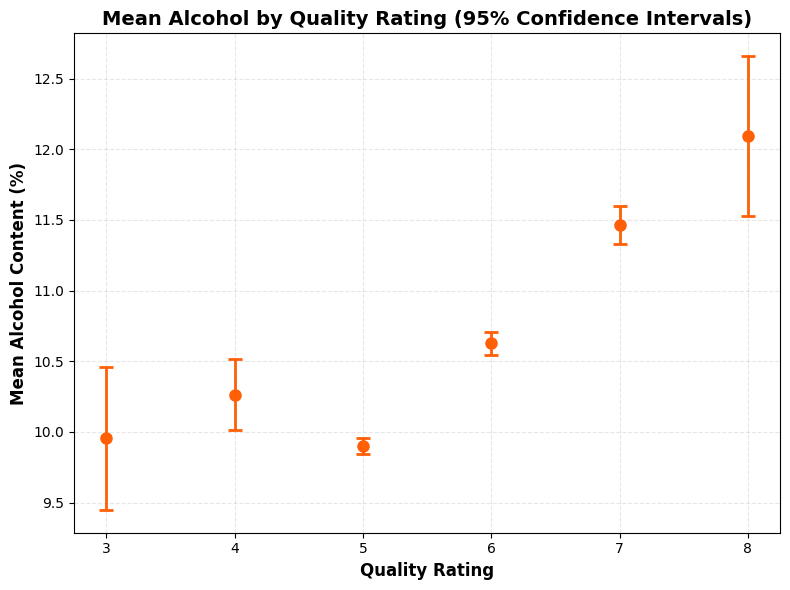

In [20]:
# Calculate summary statistics for each quality group
summary = (
    df.groupby("quality_cat", observed=True)["alcohol"]
      .agg(["mean", "count", "std"])
      .reset_index()
)

# Calculate standard error and 95% confidence intervals
# Standard error = standard deviation / sqrt(sample size)
summary["se"] = summary["std"] / np.sqrt(summary["count"])
# 95% CI = mean ± (1.96 × standard error)
summary["ci_low"] = summary["mean"] - 1.96 * summary["se"]
summary["ci_high"] = summary["mean"] + 1.96 * summary["se"]

# Create error bar plot
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=summary["quality_cat"].astype(str),
    y=summary["mean"],
    yerr=1.96 * summary["se"],  # Error bars show 95% CI
    fmt="o",
    capsize=5,
    capthick=2,
    color=illiniorange,
    markersize=8,
    linewidth=2
)
plt.xlabel("Quality Rating", fontsize=12, weight='bold')
plt.ylabel("Mean Alcohol Content (%)", fontsize=12, weight='bold')
plt.title("Mean Alcohol by Quality Rating (95% Confidence Intervals)", 
          fontsize=14, weight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### 5.2. Tukey HSD Visualization

This plot visualizes the results of the Tukey HSD test, showing which quality groups have significantly different means. Groups that are significantly different will have non-overlapping confidence intervals in this visualization.


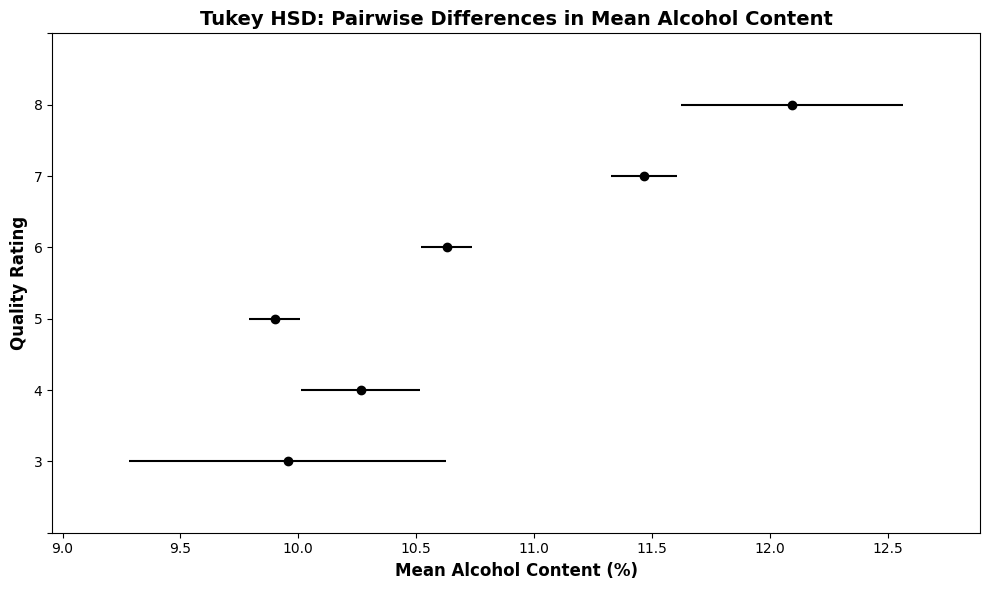

In [21]:
# Create Tukey HSD visualization
# This shows pairwise comparisons with confidence intervals
tukey = pairwise_tukeyhsd(
    endog=df["alcohol"],
    groups=df["quality_cat"],
    alpha=0.05
)

fig = tukey.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD: Pairwise Differences in Mean Alcohol Content", 
          fontsize=14, weight='bold')
plt.xlabel("Mean Alcohol Content (%)", fontsize=12, weight='bold')
plt.ylabel("Quality Rating", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


### 5.3. Residual Diagnostics

Residual plots help assess whether ANOVA assumptions are met:
- **Residuals vs. Fitted**: Should show random scatter (no patterns) - indicates homoscedasticity
- **Q-Q Plot**: Should follow a straight line - indicates normality of residuals


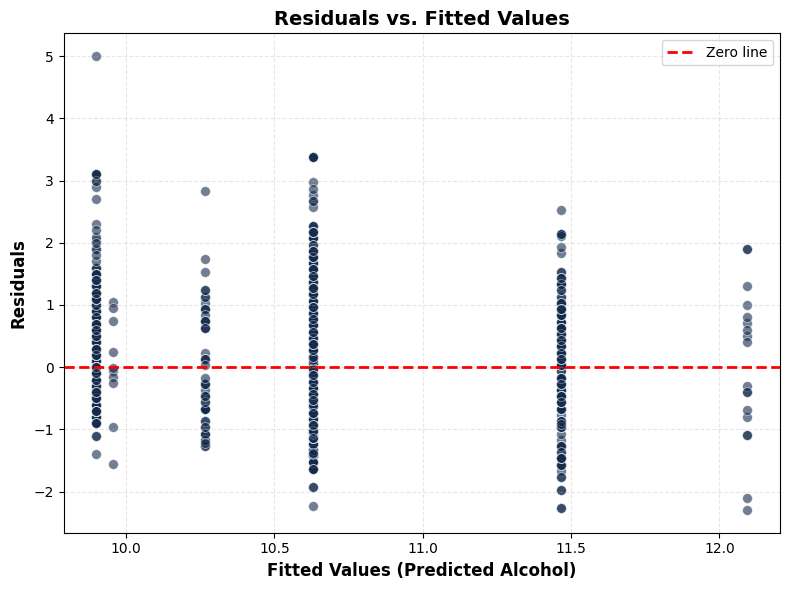

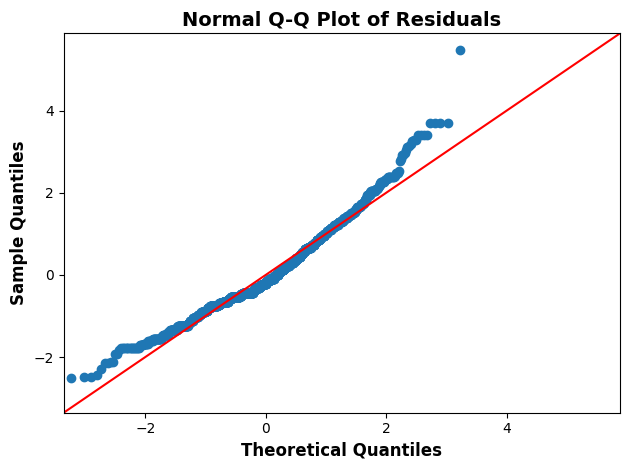

In [22]:
# Extract fitted values and residuals from the model
fitted = model.fittedvalues
resid = model.resid

# Plot 1: Residuals vs. Fitted Values
# This should show random scatter with no clear patterns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted, y=resid, alpha=0.6, color=illiniblue, s=50)
plt.axhline(0, color="red", linestyle="--", linewidth=2, label="Zero line")
plt.xlabel("Fitted Values (Predicted Alcohol)", fontsize=12, weight='bold')
plt.ylabel("Residuals", fontsize=12, weight='bold')
plt.title("Residuals vs. Fitted Values", fontsize=14, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Plot 2: Normal Q-Q Plot
# Points should fall along the diagonal line if residuals are normally distributed
fig = sm.qqplot(resid, line="45", fit=True)
plt.title("Normal Q-Q Plot of Residuals", fontsize=14, weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=12, weight='bold')
plt.ylabel("Sample Quantiles", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


## 6. Cochran's Q Test

**Cochran's Q Test** is a non-parametric test used to determine if there are differences in proportions across multiple related groups. It's particularly useful for:
- Sensory panel data where the same subjects are tested under different conditions
- Binary responses (yes/no, pass/fail) across multiple treatments
- Repeated measures designs with categorical outcomes

**Research Question:** Do the proportions of "acceptable" wines differ across different sulfur dioxide levels?

**Null Hypothesis (H₀):** The probability of "acceptable" is the same across all sulfur dioxide bands.

**Alternative Hypothesis (H₁):** At least one sulfur dioxide band has a different proportion of acceptable wines.

### 6.1. Prepare Data for Cochran's Q Test

For Cochran's Q test, we need:
- Multiple conditions (treatments) - in this example, three sulfur dioxide bands
- Binary responses (0/1) for each subject under each condition
- The same subjects tested under all conditions

In [23]:
# Create a binary "acceptable" variable
# Wines with quality >= 6 are considered acceptable
df["acceptable"] = (df["quality"] >= 6).astype(int)

# Create three conditions based on total sulfur dioxide levels
# We'll split into tertiles (three equal groups)
df["sulfur_band"] = pd.qcut(df["total sulfur dioxide"], q=3,
                            labels=["low_SO2", "mid_SO2", "high_SO2"])

print("Distribution of wines across sulfur dioxide bands:")
print(df["sulfur_band"].value_counts().sort_index())
print()

# For Cochran's Q, we need binary responses (0/1) for each wine under each condition
# In this example: Is the wine acceptable AND in this sulfur band?
# In real sensory data, this would be: Did the panelist detect a difference under this condition?
df["acc_low"] = ((df["sulfur_band"] == "low_SO2") & (df["acceptable"] == 1)).astype(int)
df["acc_mid"] = ((df["sulfur_band"] == "mid_SO2") & (df["acceptable"] == 1)).astype(int)
df["acc_high"] = ((df["sulfur_band"] == "high_SO2") & (df["acceptable"] == 1)).astype(int)

# Create the response matrix: (n_subjects × k_conditions)
# Each row is a wine, each column is a condition
responses = df[["acc_low", "acc_mid", "acc_high"]].to_numpy()
print(f"Response matrix shape: {responses.shape}")
print("(rows = wines, columns = conditions)")


Distribution of wines across sulfur dioxide bands:
sulfur_band
low_SO2     534
mid_SO2     545
high_SO2    520
Name: count, dtype: int64

Response matrix shape: (1599, 3)
(rows = wines, columns = conditions)


In [24]:
# Perform Cochran's Q test
# Input: (n_subjects × k_conditions) array of binary responses
Q, p = cochrans_q(responses)

print("Cochran's Q Test Results:")
print("="*60)
print(f"Q-statistic: {Q:.3f}")
print(f"p-value: {p:.4f}")
print()

# Interpretation
alpha = 0.05
if p < alpha:
    print(f"Result: Reject the null hypothesis (p < {alpha})")
    print("Conclusion: There is a significant difference in proportions across conditions.")
    print("The probability of 'acceptable' differs across sulfur dioxide bands.")
else:
    print(f"Result: Fail to reject the null hypothesis (p >= {alpha})")
    print("Conclusion: No significant difference in proportions across conditions.")
    print("The probability of 'acceptable' is similar across sulfur dioxide bands.")

Cochran's Q Test Results:
Q-statistic: 39.179
p-value: 0.0000

Result: Reject the null hypothesis (p < 0.05)
Conclusion: There is a significant difference in proportions across conditions.
The probability of 'acceptable' differs across sulfur dioxide bands.


/opt/anaconda3/envs/sensory/lib/python3.12/site-packages/statsmodels/sandbox/stats/runs.py:480: FutureWarning: Deprecated, use stats.cochrans_q instead
  warnings.warn("Deprecated, use stats.cochrans_q instead", FutureWarning)


Interpretation (for the teaching context):

Null hypothesis: the probability of “acceptable” is the same across the 3 sulfur-dioxide bands.

If p < 0.05, conclude evidence of a difference in acceptable proportions across bands.

For a genuine sensory panel, you would replace acc_low, acc_mid, acc_high with panelist responses (e.g., “checked/not checked” or “detected difference/not detected”) on the same subjects under multiple conditions; the code and test implementation remain the same.